In [704]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## MODEL

In [1136]:
def contraction(inputs,num_filters,dropout_rate=0.1):
    c = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c = tf.keras.layers.Dropout(dropout_rate)(c)
    c = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c)
    b = tf.keras.layers.BatchNormalization()(c)
    r = tf.keras.layers.ReLU()(b)
    p = tf.keras.layers.MaxPooling2D((2, 2))(r)
    return c,p

def expansion(inputs,skip_features,num_filters,dropout_rate=0.1):
    u = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    u = tf.keras.layers.concatenate([u, skip_features])
    u = tf.keras.layers.BatchNormalization()(u)
    u = tf.keras.layers.ReLU()(u)
    return u

def unet(input_shape,num_classes=1,nfilters=256,dropout_rate=0.1):
    inputs = tf.keras.layers.Input(input_shape)
    #Contraction path
    c1,p1=contraction(inputs,nfilters/16)
    c2,p2=contraction(p1,nfilters/8)
    c3,p3=contraction(p2,nfilters/4)
    c4,p4=contraction(p3,nfilters/2)
    #bottleneck
    c5 = tf.keras.layers.Conv2D(nfilters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #Expansive path 
    u6=expansion(c5,c4,nfilters/2)
    u7=expansion(u6,c3,nfilters/4)
    u8=expansion(u7,c2,nfilters/8)
    u9=expansion(u8,c1,nfilters/16)
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [1137]:
model = unet((288,576,1),nfilters=256)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 288, 576, 1)]        0         []                            
                                                                                                  
 conv2d_335 (Conv2D)         (None, 288, 576, 16)         160       ['input_29[0][0]']            
                                                                                                  
 dropout_147 (Dropout)       (None, 288, 576, 16)         0         ['conv2d_335[0][0]']          
                                                                                                  
 conv2d_336 (Conv2D)         (None, 288, 576, 16)         2320      ['dropout_147[0][0]']         
                                                                                            

## DATA PROCESSING

In [44]:
from PIL import Image
background1=Image.open('../imgs/background_1.png').crop((90,170,1920-90,1080-40)).resize((576,288))
background2=Image.open('../imgs/background_2.png').crop((90,170,1920-90,1080-40)).resize((576,288))
background3=Image.open('../imgs/background_3.png').crop((90,170,1920-90,1080-40)).resize((576,288))
background5=Image.open('../imgs/background_5.png').crop((90,170,1920-90,1080-40)).resize((576,288))
background6=Image.open('../imgs/background_6.png').crop((90,170,1920-90,1080-40)).resize((576,288))
char1=Image.open('../imgs/character_1x.png')
char2=Image.open('../imgs/character_2x.png')
char3=Image.open('../imgs/character_3x.png')
chars=[char1,char2,char3]
backgrounds=[background1,background2,background3,background5,background6]

In [1192]:
def get_processed(backgrounds,chars,prob=0.15):
    check=False
    if np.random.uniform(0.0,1.0)>prob:
        check=True
    if check:
        idx=np.random.randint(0,len(chars))
        char=chars[idx]
    idx=np.random.randint(0,len(backgrounds))
    background=backgrounds[idx]
    p=np.random.uniform()
    #actual
    img=background.convert('RGBA')
    if check:
        offx=np.random.randint(-30,460)
        offy=np.random.randint(-30,160)
        w,h=char.size
        factor=np.random.uniform(0.7,1.5)
        topaste=char.resize((int(w*factor),int(h*factor)))
        img.paste(topaste, (offx, offy), mask=topaste) 
    if(p>0.5):
        img=img.transpose(Image.FLIP_LEFT_RIGHT)
    bwimg=img.convert('L')
    #masked
    masked=Image.new('L',background.size)
    if check:
        masked_paste=topaste.getchannel(3)
        masked.paste(masked_paste,(offx,offy),mask=masked_paste)
    if(p>0.5):
        masked=masked.transpose(Image.FLIP_LEFT_RIGHT)
    masked=np.array(masked)
    masked[masked!=0]=1
    masked=np.array(masked,dtype=np.float32)
    return img,masked,bwimg

In [1000]:
def predict(model,img,scale=255):
    predicted=model.predict(np.array(img)[None,...]/scale)[0]
    argpred=np.argmax(predicted,axis=2)
    return argpred
def alt_predict(model,img,scale=255):
    predicted=model.predict(np.array(img)[None,...]/scale)[0,...,0]
    argpred=(predicted>0.5).astype(np.uint8)
    return argpred

In [6]:
def display_segmented(img):
    rgb=np.zeros((*img.shape,3))
    rgb[img==0,0]=1
    rgb[img==1,1]=1
    rgb[img==2,2]=1
    plt.imshow(rgb)
    plt.axis('off')

In [1207]:
def display_transp_segmented(img,mask):
    # Load the grayscale image
    grayscale_image = np.array(img)

    # Load the predicted mask
    predicted_mask = mask

    # Convert the grayscale image to RGB
    grayscale_image_rgb = np.stack([grayscale_image] * 3, axis=-1)

    color_mask = np.zeros_like(grayscale_image_rgb)
    color_mask[predicted_mask == 1] = [255, 0, 0]  # Red color for the mask

    # Blend the grayscale image and the colored mask
    alpha = 0.5  # Transparency factor
    blended_image = grayscale_image_rgb * (1 - alpha) + color_mask * alpha

    # Convert to uint8 for display
    blended_image = blended_image.astype(np.uint8)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(blended_image)
    plt.axis('off')
    plt.show()


In [774]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss function for binary image segmentation.

    Parameters:
    y_true (tensor): Ground truth binary mask, shape (batch_size, height, width, 1)
    y_pred (tensor): Predicted binary mask, shape (batch_size, height, width, 1)
    smooth (float): Smoothing factor to avoid division by zero

    Returns:
    loss (tensor): Dice Loss
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice_coefficient = (2. * intersection + smooth) / (union + smooth)
    loss = 1 - dice_coefficient
    return loss

def combined_loss(y_true, y_pred, alpha=0.5):
    """
    Combined Binary Cross-Entropy and Dice Loss.

    Parameters:
    y_true (tensor): Ground truth binary mask
    y_pred (tensor): Predicted binary mask
    alpha (float): Weighting factor for Binary Cross-Entropy loss

    Returns:
    loss (tensor): Combined loss
    """
    bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss_value = dice_loss(y_true, y_pred)
    return alpha * bce_loss + (1 - alpha) * dice_loss_value

def custom_loss(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.math.reduce_sum(tf.abs(y_true-y_pred))

In [1138]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, backgrounds, chars,length,batchsize=1):
        self.backgrounds=backgrounds
        self.chars = chars
        self.length=length
        self.batchsize=batchsize

    def __len__(self):
        return int(self.length)

    def __getitem__(self, idx):
        img,masked=get_processed(self.backgrounds,self.chars)
        return np.array(img)[None,...]/255, masked[None,...,None]  # Add a new dimension at the end
trainset = DataGenerator(backgrounds,chars,10)

In [1139]:
model.compile(optimizer='adam',loss='binary_crossentropy' ,metrics=['accuracy'])

In [1185]:
history = model.fit(trainset, epochs=1)

10/10 [==============================] - 2s 175ms/step - loss: 0.0897 - accuracy: 0.9783


In [1208]:
origimg,p,img=get_processed(backgrounds,chars)
#img,p=prova1,prova2
predicted=alt_predict(model,img,scale=255)
display_transp_segmented(origimg,predicted)

1/1 [==============================] - 0s 65ms/step


ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (6372,4)

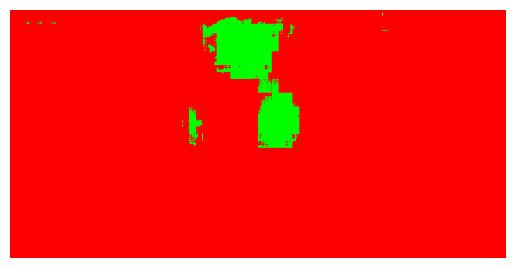

In [1057]:
display_segmented(predicted)

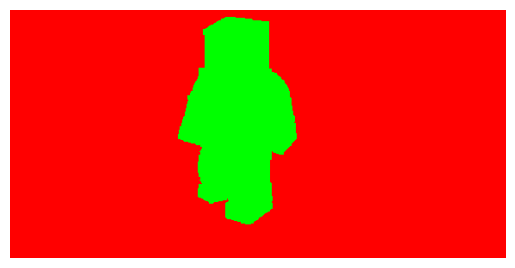

In [1059]:
display_segmented(p)

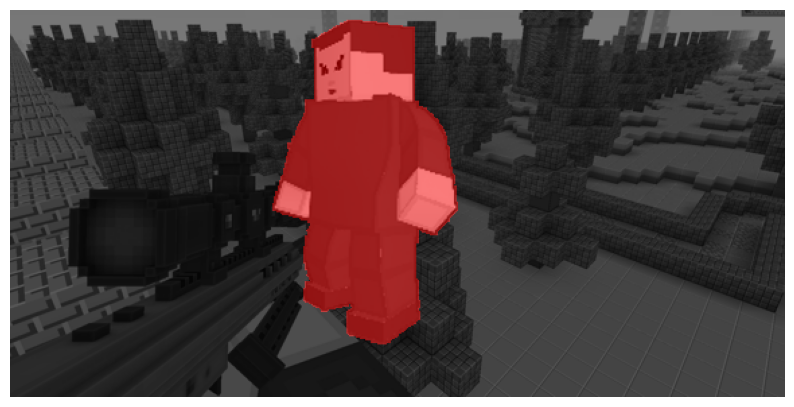

In [1058]:
display_transp_segmented(img,p)

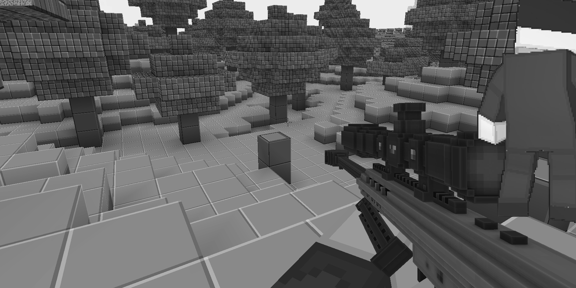

In [328]:
img

In [903]:
np.sum(predicted),len(np.reshape(predicted,-1))

(73019.6, 165888)

In [923]:
predicted=model.predict(np.array(img)[None,...,None])

1/1 [==============================] - 0s 354ms/step


In [1129]:
model.save('model.keras')

In [910]:
predicted.shape

(1, 288, 576, 1)